In [28]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns


import statsmodels.api as sm
import yfinance as yf
from scipy import stats

from sklearn.datasets import fetch_california_housing
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.robust import norms


sns.set()


# Best Practices Handbook


# Challenge 1: Skewness (Student 1)

In [29]:
right_skewed_data = np.random.exponential(size=2000)

<Axes: ylabel='Count'>

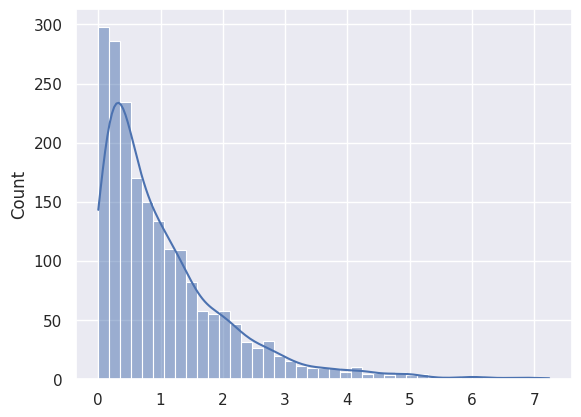

In [30]:
sns.histplot(right_skewed_data, kde=True)

In [31]:
3*(np.mean(right_skewed_data) - np.median(right_skewed_data))/np.std(right_skewed_data)

np.float64(0.9255336560874272)


# Challenge 2: Addressing Kurtosis  (Student 2)


 ## 1. Kurtosis Analysis

 ### Definition
 Kurtosis measures the "tailedness" of a probability distribution relative to a normal distribution. Given a continuous random variable $X$ under a probability distribution, the excess kurtosis of that distribution is calculated as:

 $$
 \text{Excess Kurtosis} = \frac{E((X-E(X))^4)}{E((X-E(X))^2)} - 3
 $$
 where the -3 adjustment makes normal distribution kurtosis = 0 (DeCarlo, 1997).

  ### Description
 - Positive excess kurtosis indicates heavy tails (more outliers than normal distribution). The distribution is said leptokurtic
 - negative suggests light tails. The distribution is said platykurtic.

  ### Demonstration
 For numerical demonstration, we'll simulate three distributions with different kurtosis properties:
 - Normal kurtosis: normal distribution,
 - Positive excess kurtosis: t-Student distribution,
 - Negative excess kurtosis: uniform distribution.


In [32]:
np.random.seed(90)
normal_data = np.random.normal(0, 1, 1000)
student_data = np.random.standard_t(df=3, size=1000)  # Leptokurtic
uniform_data = np.random.uniform(-np.sqrt(3), np.sqrt(3), 1000)  # Platykurtic

# Calculate kurtosis
kurtosis = {
    "Normal": stats.kurtosis(normal_data),
    "Student": stats.kurtosis(student_data),
    "Uniform": stats.kurtosis(uniform_data)
}

print("Excess Kurtosis Values:")
for dist, k in kurtosis.items():
    print(f"{dist}: {k:.2f}")

Excess Kurtosis Values:
Normal: -0.08
Student: 9.01
Uniform: -1.21



 ### Diagram
 Visual comparison of the distributions:
- **Leptokurtic distributions** (such as the Student's t-distribution) have heavier tails than the standard normal distribution, meaning they exhibit more extreme values.
- **Platykurtic distributions** (such as the uniform distribution) have thinner tails and lie below the standard normal density curve.

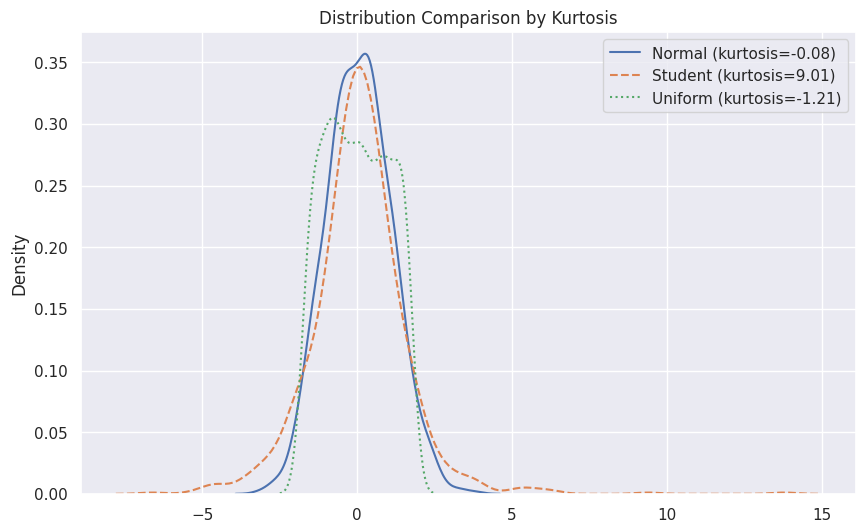

In [33]:
plt.figure(figsize=(10, 6))
sns.kdeplot(normal_data, label=f"Normal (kurtosis={kurtosis['Normal']:.2f})")
sns.kdeplot(student_data, label=f"Student (kurtosis={kurtosis['Student']:.2f})", linestyle="--")
sns.kdeplot(uniform_data, label=f"Uniform (kurtosis={kurtosis['Uniform']:.2f})", linestyle=":")
plt.title("Distribution Comparison by Kurtosis")
plt.legend()
plt.show()

 ### Diagnosis
 How to detect problematic kurtosis:
To formally detect whether the sample data has excess kurtosis, we perform a **hypothesis test**:

#### Hypothesis Test for Excess Kurtosis:
- **Null Hypothesis ($H_0$)**: The sample has **no Excess kurtosis** (excess kurtosis = 0).
- **Alternative Hypothesis ($H_1$)**: The sample has **non-normal kurtosis** (excess kurtosis $\neq$ 0).

Under the **null hypothesis**, the distribution of the test statistic for excess kurtosis should follow an **asymptotic normal distribution** for large sample sizes (Westfall, 1993).

The **kurtosistest** in the Python **SciPy** library performs this test by calculating the **excess kurtosis** and its corresponding p-value.

#### Test Statistic:
The test statistic is computed under the null hypothesis as:

$$
\text{Test Statistic} = \frac{ \hat{K}}{ \sigma_{\hat{K}} }
$$

where:
- $\hat{K}$ is the **sample excess kurtosis**,
- $\sigma_{\hat{K}}$ is the **standard error** of the sample kurtosis.

#### Decision Rule:
- If the **p-value** is **less than the significance level** (typically $ \alpha = 0.05 $), we reject the null hypothesis, indicating **significant excess kurtosis**.
- If the **p-value** is **greater than** the significance level, we fail to reject the null hypothesis, suggesting that the sample is consistent with normal kurtosis.


Below is the Python implementation using `scipy.stats.kurtosistest` to perform the test for excess kurtosis on a given data sample.


In [34]:
def diagnose_kurtosis(data, alpha=0.05):
    k = stats.kurtosis(data)
    stat, p = stats.kurtosistest(data)

    print(f"Excess Kurtosis: {k:.2f}")
    print(f"Kurtosis Test p-value: {p:.4f}")

    if p < alpha:
        print("Significant non-normal kurtosis detected (p < 0.05)")
    else:
        print("No significant kurtosis detected")

    if k > 1:
        print("Warning: Heavy tails (leptokurtic)")
    elif k < -1:
        print("Warning: Light tails (platykurtic)")


In [35]:
# Appliying the test on the samples distribution generated above

diagnose_kurtosis(normal_data) # normal distribution

Excess Kurtosis: -0.08
Kurtosis Test p-value: 0.6779
No significant kurtosis detected


In [36]:
diagnose_kurtosis(student_data) # student distribution

Excess Kurtosis: 9.01
Kurtosis Test p-value: 0.0000
Significant non-normal kurtosis detected (p < 0.05)


In [37]:
diagnose_kurtosis(uniform_data) # Uniform distribution

Excess Kurtosis: -1.21
Kurtosis Test p-value: 0.0000
Significant non-normal kurtosis detected (p < 0.05)


### Results from Hypothesis Test:
1. **Normal Distribution Sample**:
   - The test for excess kurtosis on a sample generated from a **normal distribution** resulted in a **p-value of 0.67**. This is **greater than 0.05**, meaning that we **fail to reject the null hypothesis**. Therefore, the sample does **not exhibit excess kurtosis**, and it is consistent with a normal distribution.

2. **Student's t-Distribution Sample (3 Degrees of Freedom)**:
   - The test for excess kurtosis on a sample generated from a **Student's t-distribution with 3 degrees of freedom** yielded a **p-value less than 0.05**. This indicates that we **reject the null hypothesis**, confirming that the sample **exhibits excess kurtosis**. The distribution has heavier tails compared to the normal distribution, which is typical of the Student's t-distribution.

3. **Uniform Distribution Sample**:
   - The test for excess kurtosis on a sample generated from a **Uniform** yielded a **p-value less than 0.05**. This indicates that we **reject the null hypothesis**, confirming that the sample **exhibits excess kurtosis**. In addition the statistic is negative showing that the distribution has thinner tails compared to the normal distribution.
  

   ### Damage

Ignoring kurtosis in while modeling can lead to:
- Inaccurate predictions and misleading statistical inferences.
- **Underestimation of the probability of extreme events**, which is especially problematic in financial or risk modeling contexts.
- **Incorrect modeling of dependencies** in multivariate systems, such as copula-based models.

Properly accounting for kurtosis ensures that models are more robust and capable of capturing the true behavior of the data, particularly when extreme events are more likely than assumed under normality.





 ## References
 1. DeCarlo, L. T. (1997). "On the Meaning and Use of Kurtosis." *Psychological Methods*, **2**(3), 292–307.
 3. Westfall, P. H., & Young, S. S. (1993). "Resampling-Based Multiple Testing: Examples and Methods for P-value Adjustment." *John Wiley & Sons*.


# Challenge 3: Modeling non-stationarity and finding a unit Root Testing


## 1.  Definition
A time series is **stationary** if its statistical properties (mean, variance, and autocovariance) remain constant over time. Formally, a stochastic process $X_t$ is weakly stationary if:

$$
E(X_t) = \mu, \quad Var(X_t) = \sigma^2, \quad Cov(X_t, X_{t-h}) = \gamma_h \quad \forall t,h
$$

where $\mu$ is the mean, $\sigma^2$ is the variance, and $\gamma_h$ is the autocovariance function.

### Description
Many real-world time series (e.g., stock prices, GDP, inflation) exhibit **non-stationarity**, meaning their mean and/or variance change over time.

## 2. Diagnosing Non-Stationarity


[*********************100%***********************]  1 of 1 completed


<Figure size 1000x500 with 0 Axes>

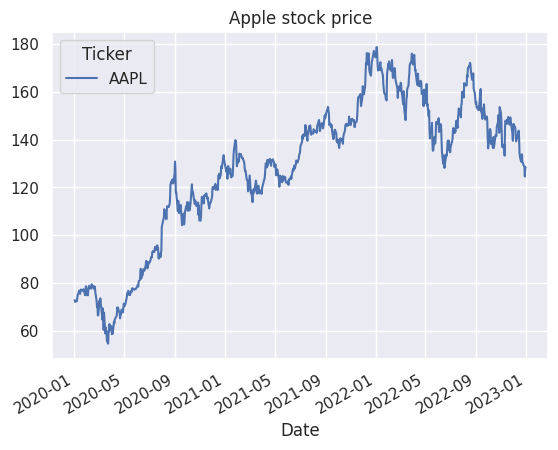

In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Generate a non-stationary time series (Random Walk)
aaple = yf.download("AAPL", start="2020-01-01", end="2023-01-01")["Close"]

# Plot the time series
plt.figure(figsize=(10, 5))
aaple.plot(title='Apple stock price')
plt.show()


## 3. Diagnosing Non-Stationarity
The Apple stock price data shown in the figure exhibit non-stationary behavior, as indicated by the presence of a clear trend. This suggests that the time series has a unit root, meaning its statistical properties, such as mean and variance, change over time.
Unlike a stationary data, non-stationary data, on the other hand, displays trend and seasonality. To formally test for non-stationarity, we use unit root tests.
Unit root testing is used to check for non-stationarity and we can use the results of the tests to decide if we would need to apply differencing to make the series stationary.
An example of a time series data that is non-stationary is the random walk (and the Apple stock as illustrated above). The value at time t depends on the value at the previous period and some random error.
The most commonly used unit root test to identify non-stationarity is the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the test is that the time series has a unit root, which indicates that the data is non-stationary. If the p-value from the test is less than 0.05, we reject the null hypothesis, suggesting that the data does not have a unit root, and is stationary.


ADF Statistic: -1.889
p-value: 0.337
The series is non-stationary (fail to reject H0)


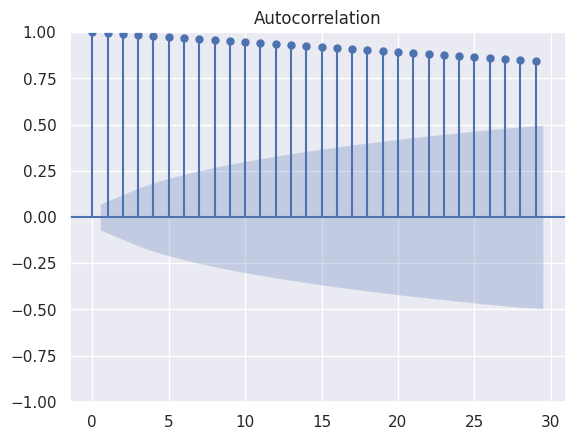

In [39]:
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    if result[1] < 0.05:
        print("The series is stationary (reject H0)")
    else:
        print("The series is non-stationary (fail to reject H0)")


plot_acf(aaple)
adf_test(aaple)

## 4. Damage Caused by Non-Stationarity
Ignoring non-stationarity in time series modeling can lead to **Spurious regression results** since all theorical properties on time series modeling  assume stationarity (ARMA).

## 5. Directions

- A common approach to removing a unit root is differencing. First differencing for example involves subtracting the previous observation from the current observation to remove any trends that might be present.


$$
\Delta X_t = X_t - X_{t-1}
$$

- If variance increases over time, log transformation stabilizes it. This transformation is common in financial analysis. When analyzing stock prices, it is common to apply the log transformation first before differencing, as this stabilizes the variance across time and can lead to better results when applying statistical models like ARIMA or other time series methods. Where “I” stands for integrated, which means differencing is applied for stationarity.

$$
Y_t = log(X_t)
$$

<Figure size 1000x500 with 0 Axes>

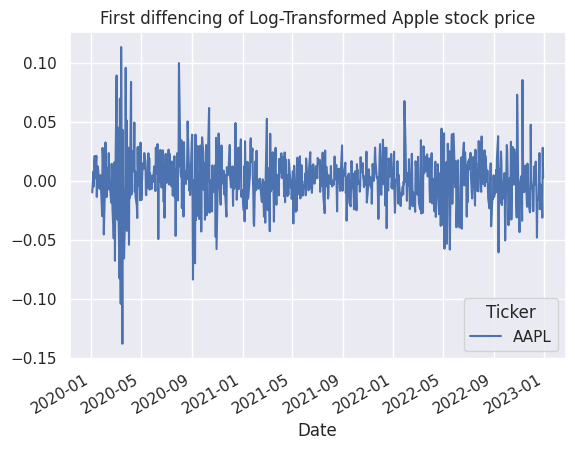

ADF Statistic: -8.749
p-value: 0.000
The series is stationary (reject H0)


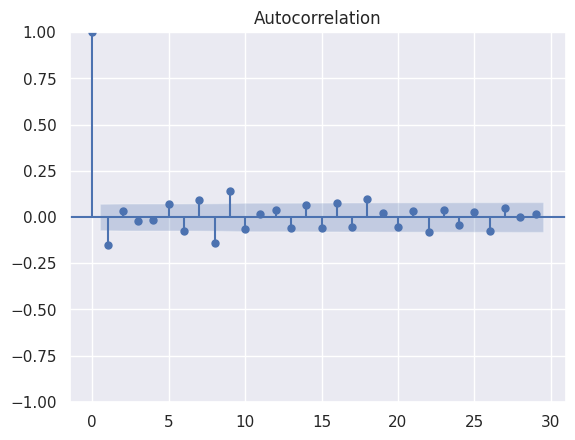

In [40]:

log_aaple = np.log(aaple) # Log transformation of Apple stock price
log_aaple_diff = log_aaple.diff().dropna() # First differencing

plt.figure(figsize=(10, 5))
log_aaple_diff.plot(title='First diffencing of Log-Transformed Apple stock price')
plt.show()

plot_acf(log_aaple_diff)
adf_test(log_aaple_diff)



After applying log transformation and first differencing to the Apple stock price data, the resulting time series appears to be stationary around the zero line. The ACF of the series resembles that of a white noise process, indicating stationarity. Furthermore, the Augmented ADF test yields a p-value of less than 0.05, leading to the rejection of the null hypothesis and confirming that the series is stationary.

To summarize, checking for stationarity is essential in time series modeling. Fortunately, the presence of a unit root that causes non-stationarity can be addressed through successive differencing.


1. Dickey, D. A., & Fuller, W. A. (1979). "Distribution of the estimators for autoregressive time series with a unit root." *Journal of the American Statistical Association*.

2. Hamilton, J. D. (1994). *Time Series Analysis*. Princeton University Press.
